In [41]:
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.optimizers import SGD
import numpy as np

In [2]:
model = VGG16()

W0814 00:37:41.897576 139874059257664 deprecation.py:506] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

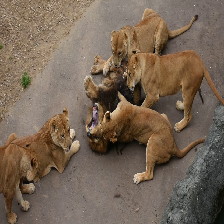

In [29]:
img_ibo = load_img("../data/input/ibo.jpg", target_size=(224,224))
img_lion = load_img("../data/input/lion.jpg", target_size=(224,224))
img_cloud = load_img("../data/input/cloud.jpg", target_size=(224,224))
img_lion

In [30]:
arr_ibo = img_to_array(img_ibo)
arr_lion = img_to_array(img_lion)
arr_cloud = img_to_array(img_cloud)
arr_ibo = preprocess_input(arr_ibo)
arr_lion = preprocess_input(arr_lion)
arr_cloud = preprocess_input(arr_cloud)
arr_input = np.stack([arr_ibo, arr_lion, arr_cloud])
arr_input.shape

(3, 224, 224, 3)

In [31]:
probs = model.predict(arr_input)
print("shape of probs:", probs.shape)
results = decode_predictions(probs)
print(results[2])

shape of probs: (3, 1000)
[('n09288635', 'geyser', 0.08019327), ('n11879895', 'rapeseed', 0.06501277), ('n07802026', 'hay', 0.060365964), ('n04467665', 'trailer_truck', 0.05819662), ('n09421951', 'sandbar', 0.05023476)]


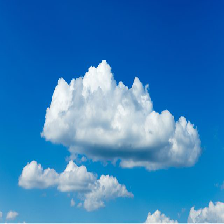

In [32]:
img_cloud

In [33]:
vgg16_ft = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16_ft.summary()

58892288/58889256 [==============================] - 10s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________________

In [37]:
def build_transfer_model(vgg16):
    model = Sequential(vgg16.layers)
    for layer in model.layers[:15]:
        layer.trainable = False
        model.add(Flatten())
        model.add(Dense(256, activation="relu"))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation="sigmoid"))
        return model

model = build_transfer_model(vgg16_ft)

In [40]:
model.compile(
    loss="binary_crossentropy",
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=["accuracy"]
)
model.summary()

W0814 02:00:02.167258 139874059257664 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [44]:
idg_train = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [48]:
img_itr_train = idg_train.flow_from_directory(
    "/home/ec2-user/SageMaker/StartTensorFlow/data/input",
    target_size=(224,224),
    batch_size=16,
    class_mode="binary"
)

Found 0 images belonging to 1 classes.


In [49]:
img_itr_validation = idg_train.flow_from_directory(
    "/home/ec2-user/SageMaker/StartTensorFlow/data/input",
    target_size=(224,224),
    batch_size=16,
    class_mode="binary"
)

Found 0 images belonging to 1 classes.


In [50]:
# 転移学習用に画像データセットを用意するのがめんどう